# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts.data_utils import load_CIFAR10


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [17]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)


print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



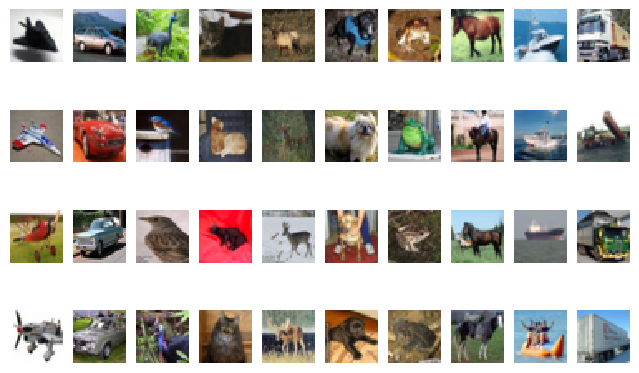

In [18]:
index_class = list()
for i in range(0, 10):
    index_class.append(np.where(y_train == i)[0])

fig = plt.figure(figsize=(8, 5))
posit = 1
for i in range(1, 5):
    for j in range(1, 11):
        normilized_im = X_train[index_class[j-1][i-1]].astype(np.float64) / 255.0
        plt.subplot(4, 10, posit)  # 2 rows, 2 columns, first position
        plt.imshow(normilized_im)  
        plt.axis('off')  # Hide the axis labels
        posit += 1


1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [19]:
new_size = np.prod(X_train[0].shape)
for i, image in enumerate(X_train):
    X_train = X_train.reshape(X_train.shape[0], new_size)
print(X_train.shape)
new_size = np.prod(X_test[0].shape)
for i, image in enumerate(X_test):
    X_test = X_test.reshape(10000, new_size)
print(X_test.shape)

(50000, 3072)
(10000, 3072)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [20]:
from scripts.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [21]:
result = classifier.predict(X_test)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


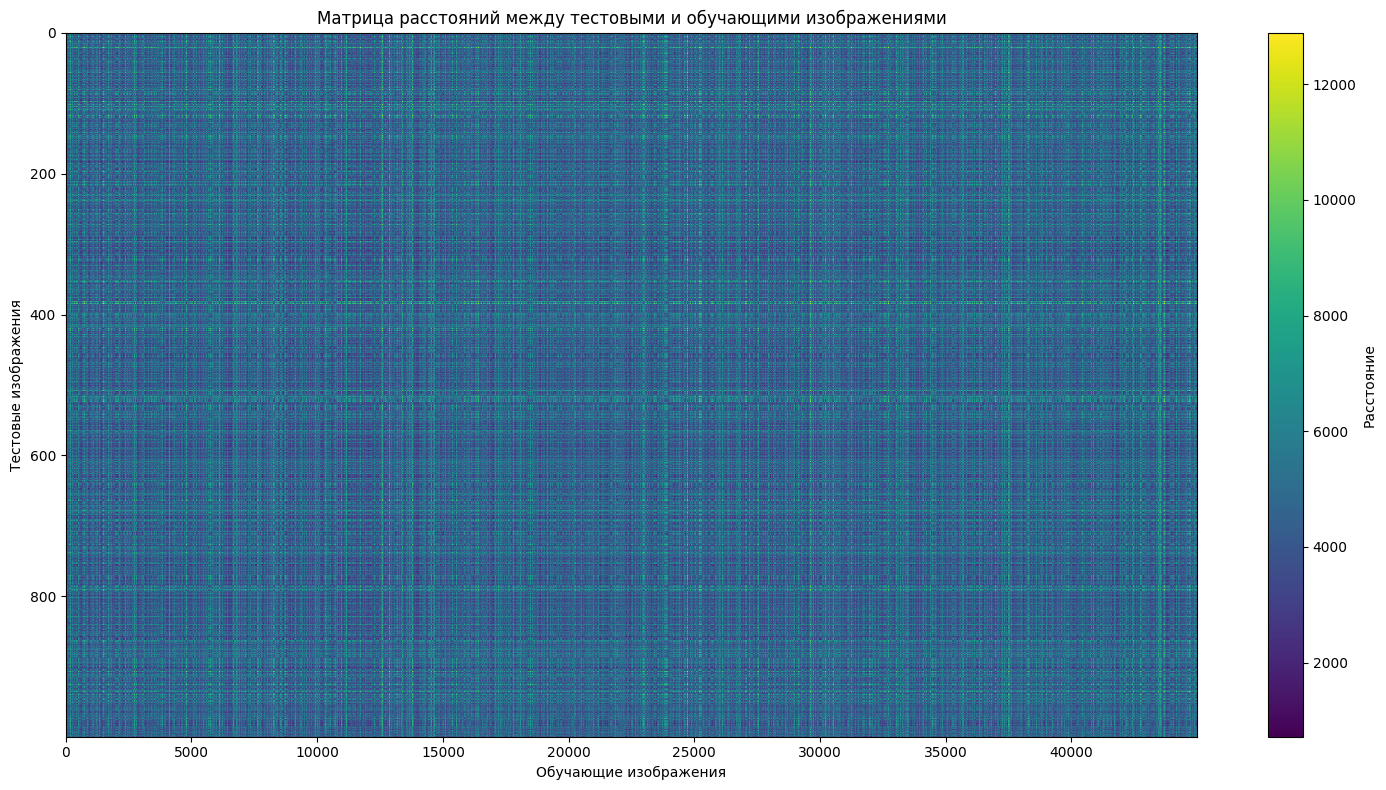

In [ ]:
plt.figure(figsize=(15, 8))

num_test = 1000 # Кол-во тестовых изображений для отображения расстояний
num_train = X_train.shape[0]

dists_subset = classifier.dists[:num_test, :num_train] # Уменьшение матрицы расстояний, иначе занимает слишком много ОЗУ при отображении

# Создаем heatmap
plt.imshow(dists_subset, interpolation='nearest', cmap='viridis', aspect='auto')
plt.colorbar(label='Расстояние')
plt.xlabel('Обучающие изображения')
plt.ylabel('Тестовые изображения')
plt.title('Матрица расстояний между тестовыми и обучающими изображениями')

plt.tight_layout()
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [ ]:
print("Доля правильно классифицированных изображений: ", np.mean(result == y_test))

Доля правильно классифицированных изображений:  0.3539


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

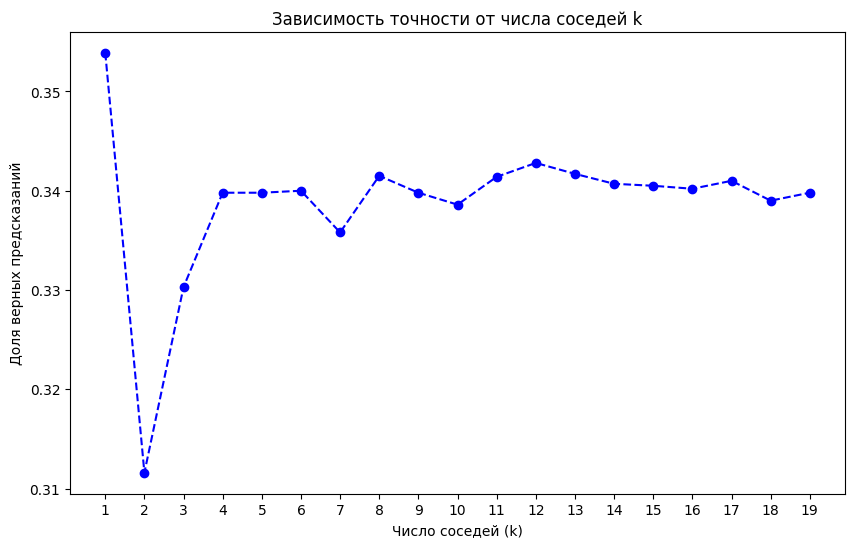

In [ ]:
coincidences = []
k_values = range(1, 20)
for k in k_values:
    result = classifier.predict_labels(classifier.dists, k = k)
    coincidences.append(coincidence(result, y_test))
plt.figure(figsize=(10, 6))
plt.plot(k_values, coincidences, marker='o', linestyle='--', color='b')
plt.title('Зависимость точности от числа соседей k')
plt.xlabel('Число соседей (k)')
plt.ylabel('Доля верных предсказаний')
plt.xticks(k_values)
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [ ]:
#Выполняет очень долго, у меня заняло ~50 мин.

num_folds=5
num_samples = X_train.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Создание фолдов для кросс-валидации
fold_size = num_samples // num_folds
folds = [indices[i * fold_size: (i + 1) * fold_size] for i in range(num_folds)]

mean_accuracies = {k: [] for k in k_values}

for k in k_values:
    for i in range(num_folds):
        # Создание тренеровочных и тестовых наборов
        test_indices = folds[i]
        train_indices = np.concatenate(folds[:i] + folds[i + 1:])

        X_train_val, X_test_val = X_train[train_indices], X_train[test_indices]
        y_train_val, y_test_val = y_train[train_indices], y_train[test_indices]

        # Тренеровка модели
        model = KNearestNeighbor()
        model.train(X_train_val, y_train_val)

        # Предсказание модели
        y_pred = model.predict(X_test_val, k=k)

        # Подсчёт точности
        accuracy = np.mean(y_pred == y_test_val)
        mean_accuracies[k].append(accuracy)

# Calculate mean accuracy for each k
for k in k_values:
    mean_accuracies[k] = np.mean(mean_accuracies[k])

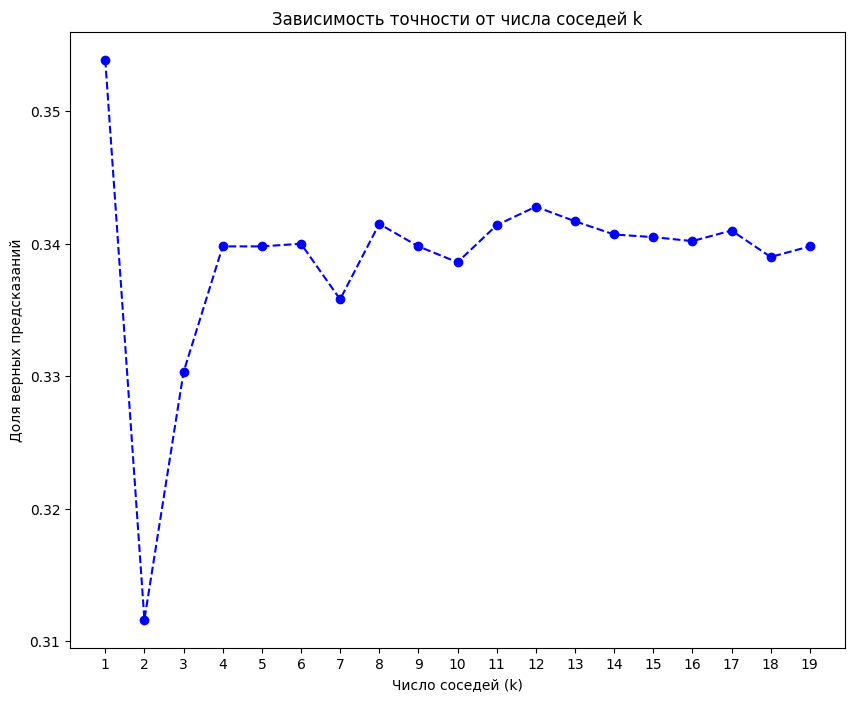

In [ ]:
plt.plot(k_values, coincidences, marker='o', linestyle='--', color='b')
plt.title('Зависимость точности от числа соседей k')
plt.xlabel('Число соседей (k)')
plt.ylabel('Доля верных предсказаний')
plt.xticks(k_values)
plt.show()


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [ ]:
classifier.train(X_train, y_train)
k = 12
result = classifier.predict(X_test, k = k)
print(f"Доля верных предсказаний при k = {k}: {np.mean(result == y_test)}")

Доля верных предсказаний при k = 12: 0.3428


1.11 Сделайте выводы по результатам 1 части задания.

In [ ]:
#Из графиков видно, что наиболее точные предсказания получились при k=1, но такой параметр может привести к переобучению.
#Верояно стоит использовать k=12. Результат в 30-35% для данной модели можно считать хорошим. Но в реальных условиях стоит использовать что-то более точное.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[-2.08701749e-13 -4.51655069e-14  6.91824198e-14  1.80821189e-13
 -1.48976369e-13  1.26902933e-14 -3.67205644e-13  4.52223503e-14
  6.26130259e-14  1.65303504e-13]


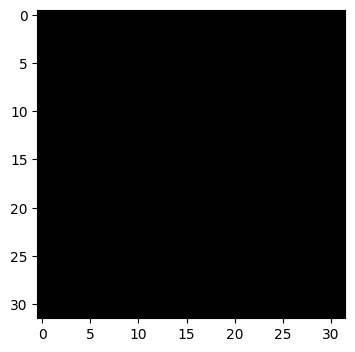

NameError: name 'X_val' is not defined

In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [ ]:

from scripts.classifiers.linear_svm import svm_loss_naive
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))


2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

2.9 Сделайте выводы по второй части задания

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts.data_utils import load_CIFAR10


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_val, y_val
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1, 
    random_state=42
)


print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

new_size = np.prod(X_train[0].shape)
for i, image in enumerate(X_train):
    X_train = X_train.reshape(X_train.shape[0], new_size)
print('Training data shape: ', X_train.shape)
new_size = np.prod(X_val[0].shape)
for i, image in enumerate(X_val):
    X_val = X_val.reshape(X_val.shape[0], new_size)
print('Validation data shape: ', X_val.shape)
new_size = np.prod(X_test[0].shape)
for i, image in enumerate(X_test):
    X_test = X_test.reshape(10000, new_size)
print('Test data shape: ', X_test.shape)

Training data shape:  (45000, 32, 32, 3)
Training labels shape:  (45000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Training data shape:  (45000, 3072)
Validation data shape:  (5000, 3072)
Test data shape:  (10000, 3072)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[130.8046     136.21415556 132.71115556 130.24088889 135.59737778
 132.00917778 131.13768889 136.38624444 132.71897778 131.63717778]


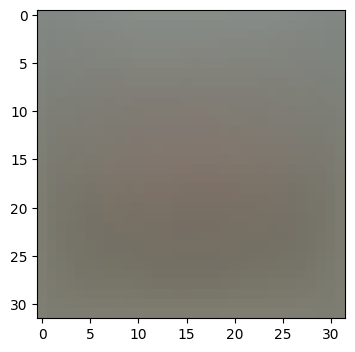

(45000, 3073) (5000, 3073) (10000, 3073)


In [3]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [4]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

X_dev, y_dev = X_val[:3073], y_val[:3073]

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.334953
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [5]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.231207 analytic: -3.231208, relative error: 1.409577e-08
numerical: -5.655141 analytic: -5.655141, relative error: 1.934292e-09
numerical: -0.188562 analytic: -0.188562, relative error: 1.582105e-07
numerical: -1.001422 analytic: -1.001422, relative error: 7.577896e-09
numerical: -0.583196 analytic: -0.583196, relative error: 2.866072e-09
numerical: -2.327720 analytic: -2.327720, relative error: 2.743770e-08
numerical: 0.613227 analytic: 0.613227, relative error: 8.195625e-08
numerical: 0.622147 analytic: 0.622147, relative error: 5.685659e-08
numerical: 0.152302 analytic: 0.152302, relative error: 1.596181e-07
numerical: -0.916008 analytic: -0.916008, relative error: 9.196509e-09
numerical: 1.821454 analytic: 1.821454, relative error: 1.149610e-08
numerical: -0.442768 analytic: -0.442768, relative error: 1.151192e-07
numerical: -1.241932 analytic: -1.241932, relative error: 1.276901e-08
numerical: 0.920683 analytic: 0.920683, relative error: 7.143245e-09
numerical: 1.337

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [6]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.334953e+00 computed in 0.339824s
vectorized loss: 2.334953e+00 computed in 0.018002s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [12]:
from scripts.classifiers.linear_classifier import Softmax
softmax_classifier = Softmax()

# Обучение классификатора
loss_history = softmax_classifier.train(X_train, y_train, learning_rate=1e-6, reg=1e-5, num_iters=3000, batch_size=300, verbose=True)

# Предсказание на тестовой выборке
y_test_pred = softmax_classifier.predict(X_test)

# Оценка точности
accuracy = np.mean(y_test_pred == y_test)  # Сравнение предсказанных и реальных меток
print(f'Accuracy на тестовой выборке: {accuracy * 100:.2f}%')

iteration 0 / 3000: loss 6.770115
iteration 100 / 3000: loss 2.729403
iteration 200 / 3000: loss 2.347510
iteration 300 / 3000: loss 2.338624
iteration 400 / 3000: loss 2.246299
iteration 500 / 3000: loss 2.324879
iteration 600 / 3000: loss 2.187208
iteration 700 / 3000: loss 2.157382
iteration 800 / 3000: loss 2.351250
iteration 900 / 3000: loss 2.037121
iteration 1000 / 3000: loss 1.913568
iteration 1100 / 3000: loss 1.805941
iteration 1200 / 3000: loss 1.915128
iteration 1300 / 3000: loss 1.954345
iteration 1400 / 3000: loss 1.851038
iteration 1500 / 3000: loss 1.935687
iteration 1600 / 3000: loss 1.914366
iteration 1700 / 3000: loss 1.980069
iteration 1800 / 3000: loss 1.846234
iteration 1900 / 3000: loss 1.903758
iteration 2000 / 3000: loss 1.946800
iteration 2100 / 3000: loss 1.943447
iteration 2200 / 3000: loss 1.850485
iteration 2300 / 3000: loss 1.883227
iteration 2400 / 3000: loss 2.013236
iteration 2500 / 3000: loss 1.897681
iteration 2600 / 3000: loss 1.771899
iteration 270

3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [15]:
# Определяем диапазоны параметров
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]  
regs = [2.5e4, 3e4, 3.5e4, 4e4, 5e4]            

best_acc = -1
best_lr = None
best_reg = None

# Перебираем все комбинации
for lr in learning_rates:
    for reg in regs:
        print(f"Testing lr={lr}, reg={reg}")
        
        # Инициализация и обучение
        model = Softmax()
        model.train(
            X_train, y_train, 
            learning_rate=lr, 
            reg=reg,
            num_iters=3000,
            batch_size=200,
            verbose=False
        )
        
        # Оценка на валидации
        y_val_pred = model.predict(X_val)
        acc = np.mean(y_val_pred == y_val)
        print(f"Validation accuracy: {acc:.4f}")
        
        # Сохраняем лучшие параметры
        if acc > best_acc:
            best_acc = acc
            best_lr = lr
            best_reg = reg

print(f"\nBest params: lr={best_lr}, reg={best_reg}, val_acc={best_acc:.4f}")

X_train_val = np.vstack([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

final_model = Softmax()
final_model.train(
    X_train_val, y_train_val,
    learning_rate=best_lr,
    reg=best_reg,
    num_iters=3000,
    batch_size=200,
    verbose=True
)

# Оценка на тесте
y_test_pred = final_model.predict(X_test)
test_acc = np.mean(y_test_pred == y_test)
print(f"\nTest accuracy: {test_acc * 100:.2f}%")


Testing lr=1e-07, reg=25000.0
Validation accuracy: 0.3198
Testing lr=1e-07, reg=30000.0
Validation accuracy: 0.3132
Testing lr=1e-07, reg=35000.0
Validation accuracy: 0.3010
Testing lr=1e-07, reg=40000.0
Validation accuracy: 0.2984
Testing lr=1e-07, reg=50000.0
Validation accuracy: 0.2910
Testing lr=1e-06, reg=25000.0
Validation accuracy: 0.3172
Testing lr=1e-06, reg=30000.0
Validation accuracy: 0.3102
Testing lr=1e-06, reg=35000.0
Validation accuracy: 0.2966
Testing lr=1e-06, reg=40000.0
Validation accuracy: 0.2902
Testing lr=1e-06, reg=50000.0
Validation accuracy: 0.2926
Testing lr=1e-05, reg=25000.0
Validation accuracy: 0.1032
Testing lr=1e-05, reg=30000.0
Validation accuracy: 0.1568
Testing lr=1e-05, reg=35000.0
Validation accuracy: 0.1242
Testing lr=1e-05, reg=40000.0
Validation accuracy: 0.1196
Testing lr=1e-05, reg=50000.0
Validation accuracy: 0.0872
Testing lr=0.0001, reg=25000.0
Validation accuracy: 0.0952
Testing lr=0.0001, reg=30000.0
Validation accuracy: 0.0952
Testing lr=0

3.10 Сделайте выводы по третьей части задания

In [ ]:
# В результате кросс-валидации были подобраны параметры, которые позволяют моделе предсказывать с точностью ~33%, что достаточно неплохо для Softmax модели.